In [33]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib
from matplotlib.lines import Line2D
import calendar as cal
import plotly.figure_factory as ff
import matplotlib.dates as mdates

from modules import utils as ut
from modules import data_processing as dp
from modules import data_retrieval as dr 
from modules import statistics as st
from modules import seasonal_data_grouper as sdg
from eval import *
%matplotlib inline

## AVAILABLE STATIONS

In [2]:
dict_of_names = {}
with open('modules/conv_stat_names.json') as file:
    dict_of_names = json.load(file)

dict_of_names['stations']

{'Ispra': 'IPR',
 'Montseny': 'MSY',
 'OPE': 'OPE',
 'Payerne': 'PAY',
 'Rigi': 'RIG',
 'Paris_SIRTA': 'SIR',
 'Athens_Demokritos': 'DEM',
 'Barcelona_PalauReial': 'BCN',
 'Marseille': 'MAR',
 'Krakow': 'KRA',
 'Helsinki': 'HEL',
 'Hyytiala': 'HYY'}

### MASS 

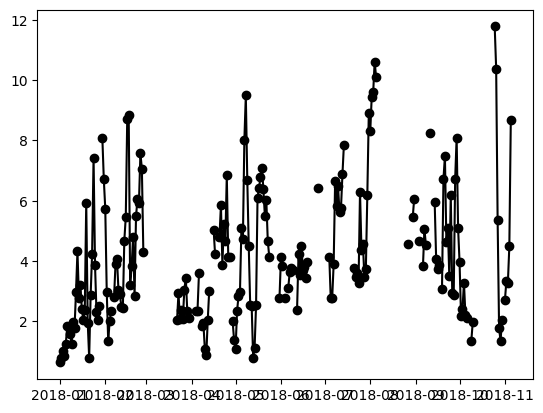

In [3]:
stn = "BCN"
data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], 
            remove_negatives=True)
data_mod_tot = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]).sum(axis=1),
                         columns=['pm2p5oa'])
data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))

plt.plot(data_obs, 
            marker="o", 
            color="black", 
            linestyle='-', 
            label=stn)
plt.rcParams.update(plt.rcParamsDefault)

plt.show()

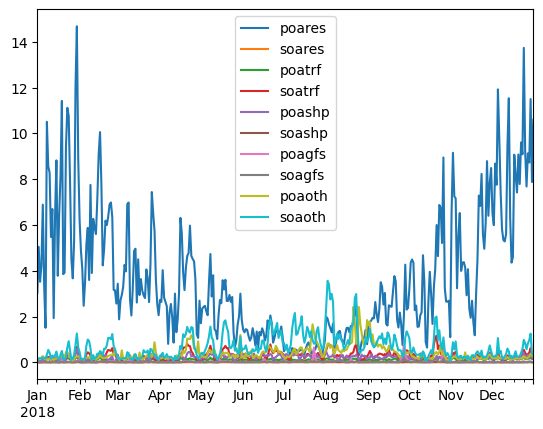

In [4]:
data_mod_sa.plot()
plt.show()

In [5]:
df = data_mod_sa.copy()
# Sumar pares de columnas y crear una nueva columna para cada suma
df['oares'] = df['poares'] + df['soares']
df['oatrf'] = df['poatrf'] + df['soatrf']
df['oashp'] = df['poashp'] + df['soashp']
df['oagfs'] = df['poagfs'] + df['soagfs']
df['oaoth'] = df['poaoth'] + df['soaoth']
# Eliminar las columnas sobrantes
columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
df = df.drop(columns=columnas_a_eliminar)

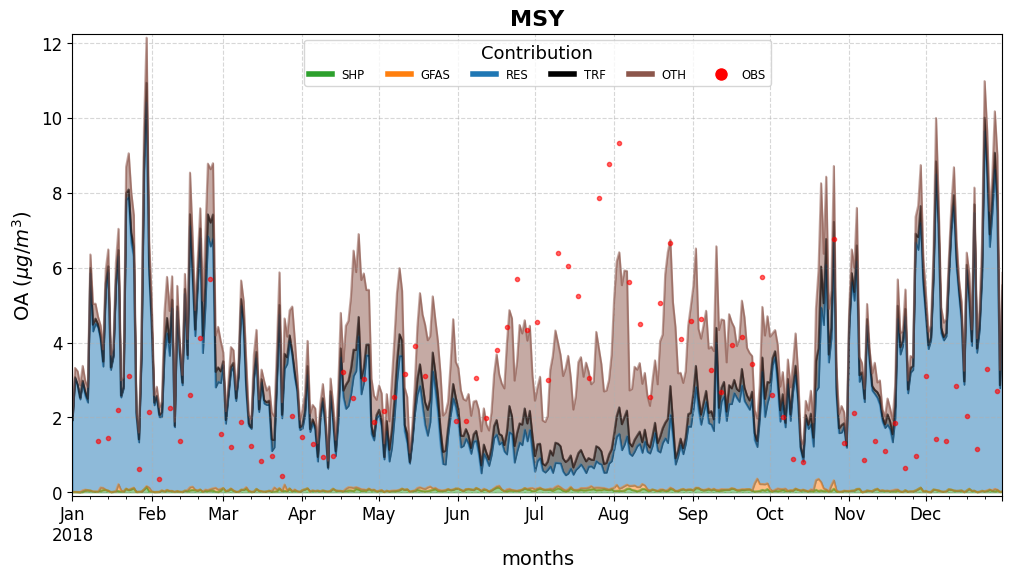

In [6]:

def plot_mass_contributions(stn):
    # Obtener datos de observaciones y modelo
    data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
    data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
    
    # Crear DataFrame para las contribuciones
    df = data_mod_sa.copy()
    df['oares'] = df['poares'] + df['soares']
    df['oatrf'] = df['poatrf'] + df['soatrf']
    df['oashp'] = df['poashp'] + df['soashp']
    df['oagfs'] = df['poagfs'] + df['soagfs']
    df['oaoth'] = df['poaoth'] + df['soaoth']
    
    # Eliminar columnas sobrantes
    columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
    df = df.drop(columns=columnas_a_eliminar)
    
    # Ordenar las categorías
    orden_categorias = ['oashp', 'oagfs', 'oares', 'oatrf', 'oaoth']
    df = df[orden_categorias]
    
    # Definir colores y etiquetas personalizadas
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#2ca02c',
        'oaoth': '#8c564b'
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RES',
        'oatrf': 'TRF',
        'oashp': 'SHP',
        'oaoth': 'OTH'
    }
    
    # Crear el gráfico de áreas
    ax = df.plot.area(stacked=True, alpha=0.5, color=[colores.get(col, 'gray') for col in df.columns], figsize=(12, 6))
    
    # Añadir puntos de observación
    color_obs = 'red'
    ax.plot(data_obs, color=color_obs, marker='o', linestyle='--', ms=3, lw=0.8, alpha=0.6)
    
    # Añadir títulos y etiquetas
    plt.title(stn, fontsize=16, fontweight='bold')
    plt.xlabel('months', fontsize=14)
    plt.ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Añadir rejilla
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Crear una lista de etiquetas con colores personalizados
    etiquetas_con_colores = [
        (etiquetas_personalizadas.get(col, col), colores.get(col, None))
        for col in df.columns
    ]
    
    # Añadir leyenda con etiquetas personalizadas y colores
    handles = [plt.Line2D([0], [0], color=color, lw=4) for etiqueta, color in etiquetas_con_colores]
    labels = [etiqueta for etiqueta, _ in etiquetas_con_colores]
    
    # Añadir leyenda de observaciones
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    labels.append('OBS')
    
    plt.legend(handles=handles, labels=labels, loc='upper center', fontsize='small', title='Contribution', title_fontsize='13', ncol=6)

    #set limite del eje y como el maximo entre mod y obs 
    max_df = df.sum(axis=1).values.max()
    max_data_obs = data_obs.max().values[0]

    # Obtener el máximo entre max_df y max_data_obs
    max_val = max(max_df, max_data_obs)
    plt.ylim(-0.1, max_val+0.1)

    #crear carpeta para guardar figuras
    os.makedirs("figures_paper", exist_ok=True)
    #guardar figura
    plt.savefig("figures_paper/{}_mass_contributions.png".format(stn), dpi=300, bbox_inches='tight')
    # Mostrar el gráfico
    plt.show()

# Llama a la función con el nombre de la estación
plot_mass_contributions('MSY')

In [7]:
#ut.plot_line_mass('RIG')

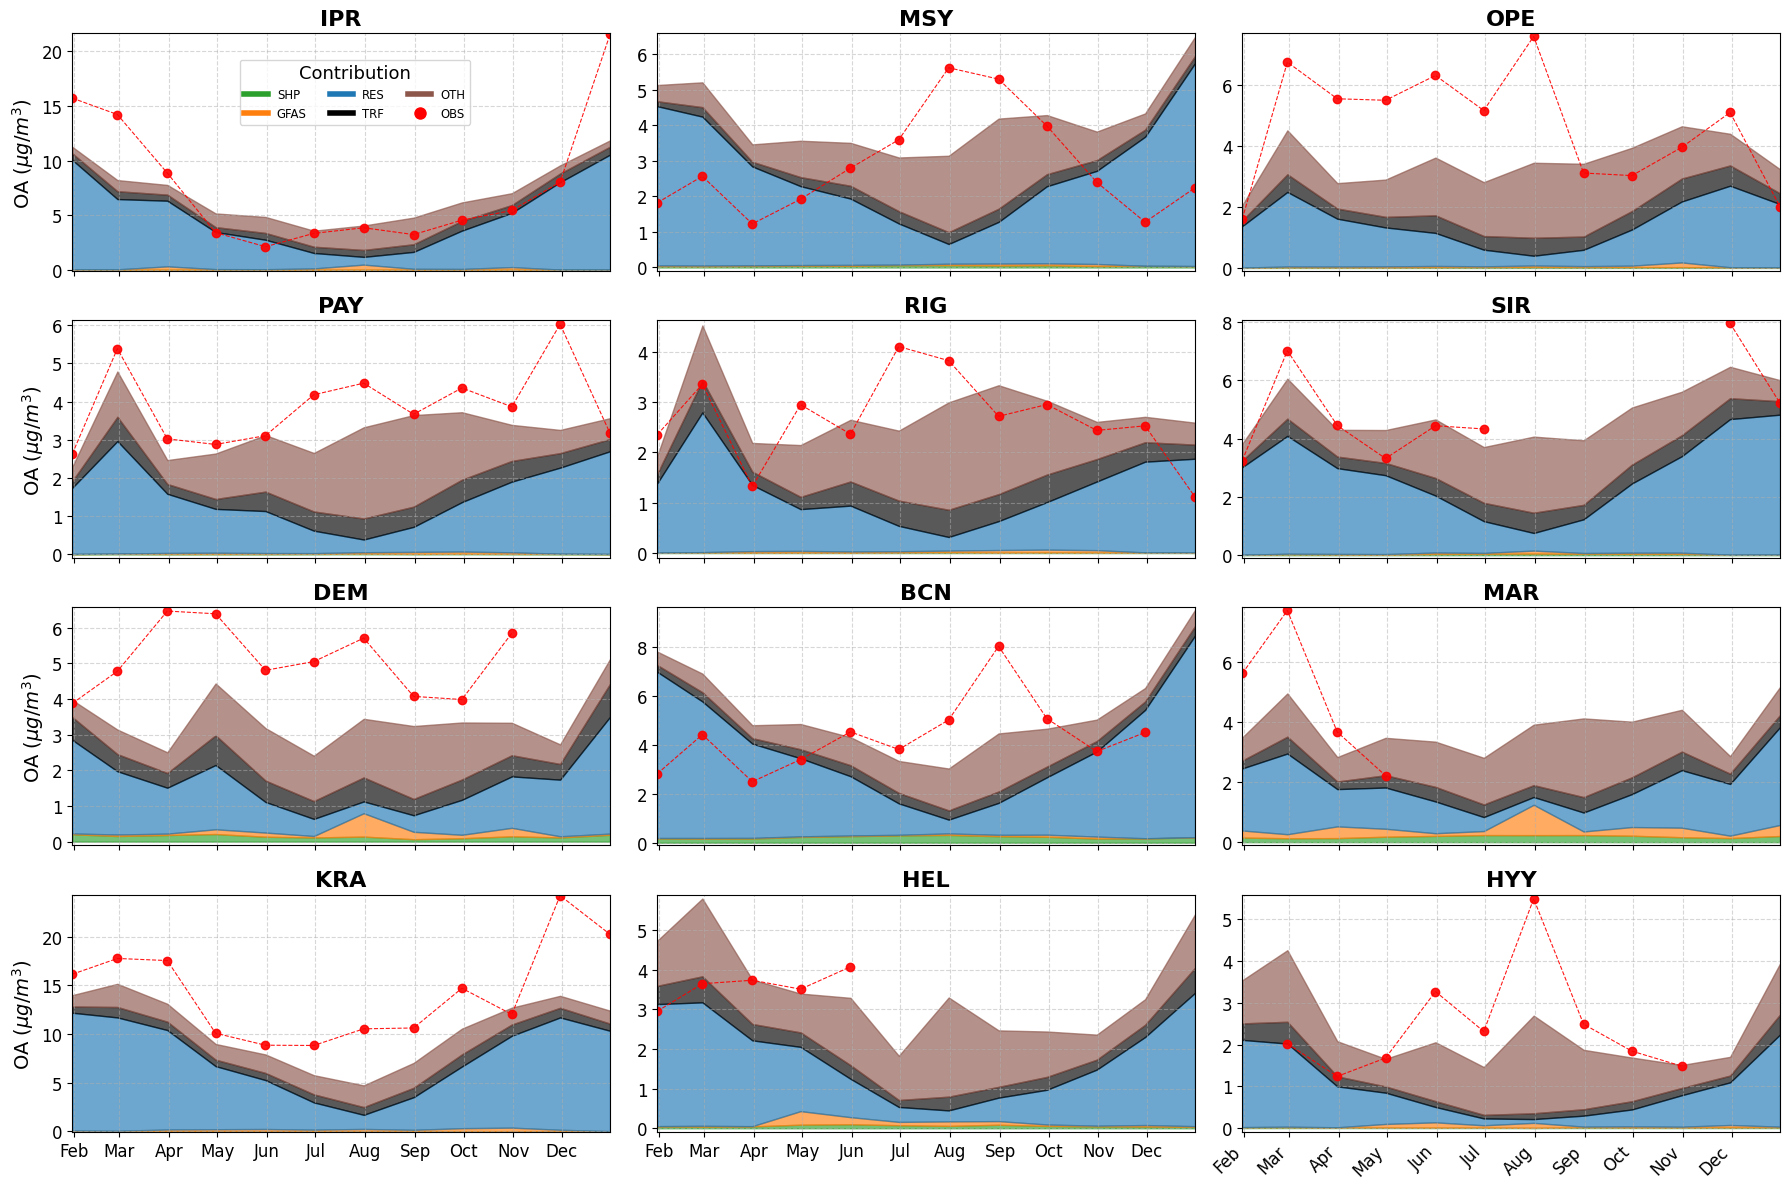

In [39]:

def plot_mass_contributions_panel(stations, m_o_y=True):
    fig, axs = plt.subplots(4, 3, figsize=(18, 12), sharex=True, sharey=False)
    axs = axs.flatten()  # Convertir la matriz de ejes en una lista para facilitar la iteración

    # Definir colores y etiquetas personalizadas fuera del bucle
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#2ca02c',  # Verde
        'oaoth': '#8c564b'   # Marrón
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RES',
        'oatrf': 'TRF',
        'oashp': 'SHP',
        'oaoth': 'OTH'
    }

    for idx, stn in enumerate(stations):
        ax = axs[idx]
        
        # Obtener datos de observaciones y modelo
        
    
        if m_o_y:
            data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
            data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
            #Resample to monthly mean
            data_obs = data_obs.resample('M').mean()
            data_mod_sa = data_mod_sa.resample('M').mean()

            # Asegurar que los índices estén en formato datetime
            #data_obs.index = pd.to_datetime(data_obs.index)
            #data_mod_sa.index = pd.to_datetime(data_mod_sa.index)
            #data_obs, data_mod_sa = data_obs.align(data_mod_sa, join='inner', axis=0)

        else:
            data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
            data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))

        # Crear DataFrame para las contribuciones
        df = data_mod_sa.copy()
        df['oares'] = df['poares'] + df['soares']
        df['oatrf'] = df['poatrf'] + df['soatrf']
        df['oashp'] = df['poashp'] + df['soashp']
        df['oagfs'] = df['poagfs'] + df['soagfs']
        df['oaoth'] = df['poaoth'] + df['soaoth']
        
        # Eliminar columnas sobrantes
        columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
        df = df.drop(columns=columnas_a_eliminar)
        
        # Ordenar las categorías
        orden_categorias = ['oashp', 'oagfs', 'oares', 'oatrf', 'oaoth']
        df = df[orden_categorias]
        
        # Crear el gráfico de áreas en el eje correspondiente
        #df.plot.area(ax=ax, stacked=True, alpha=0.25, color=[colores.get(col, 'gray') for col in df.columns], legend=False)
        df['acumulado'] = 0

        # Iterar a través de cada categoría que deseas graficar
        for col in df.columns[:-1]:  # Excluye la columna 'acumulado' que agregaste
            # Sumar la columna actual a la columna 'acumulado'
            df['acumulado'] += df[col]

            # Graficar la columna 'acumulado'
            ax.fill_between(df.index, df['acumulado'], df['acumulado'] - df[col], 
                            color=colores.get(col, 'gray'), alpha=0.65)

        # Opcional: Eliminar la columna 'acumulado' si ya no la necesitas
        df = df.drop(columns=['acumulado'])
        # Añadir puntos de observación
        color_obs = 'red'
        ax.plot(data_obs, color=color_obs, marker='o', linestyle='--', ms=3 if m_o_y==False else 6, lw=0.8, alpha=0.9)
        
        # Añadir títulos y etiquetas
        ax.set_title(stn, fontsize=16, fontweight='bold')
        #ax.set_xlabel('months', fontsize=14)
        #ax.set_ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        if idx in [0, 3, 6, 9]:
            ax.set_title(stn, fontsize=16, fontweight='bold')
            ax.set_ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
        # Añadir rejilla
        ax.grid(True, linestyle='--', alpha=0.5)
        

        max_df = df.sum(axis=1).values.max()
        max_data_obs = data_obs.max().values[0]
        
        max_val = max(max_df, max_data_obs)
        ax.set_ylim(-0.1, max_val + 0.1)

        # Configurar el formato de las etiquetas del eje x para que muestren las iniciales de los meses
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Colocar un tick por cada mes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b da el nombre abreviado del mes en inglés
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Coloca un tick cada 1 mes
    ax.set_xlim(df.index.min(), df.index.max())

    # Rotar las etiquetas para que se muestren mejor
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

    # Ajustar espaciado entre subgráficos
    plt.tight_layout()

    # Crear una sola leyenda para todos los subgráficos
    etiquetas_con_colores = [
        (etiquetas_personalizadas.get(col, col), colores.get(col, None))
        for col in df.columns
    ]
    
    handles = [plt.Line2D([0], [0], color=color, lw=4) for etiqueta, color in etiquetas_con_colores]
    labels = [etiqueta for etiqueta, _ in etiquetas_con_colores]
    
    color_obs = 'red'  # Definir color de observaciones
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    labels.append('OBS')

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.20, 0.95), fontsize='small', title='Contribution', title_fontsize='13', ncol=3)

    # Crear carpeta para guardar figuras
    os.makedirs("figures_paper", exist_ok=True)
    # Guardar figura
    plt.savefig(f"figures_paper/mass_contributions_panel_{'m' if m_o_y==True else 'y'}.png", dpi=300, bbox_inches='tight')
    # Mostrar el gráfico
    plt.show()


# Llama a la función con la lista de nombres de las estaciones
stations = dict_of_names['stations'].values()
plot_mass_contributions_panel(stations, m_o_y=True)

## Donut mass contribution

0.2917920076288283
5.89950866997242
258.73425006866455
30.481663942337036
64.59275364875793


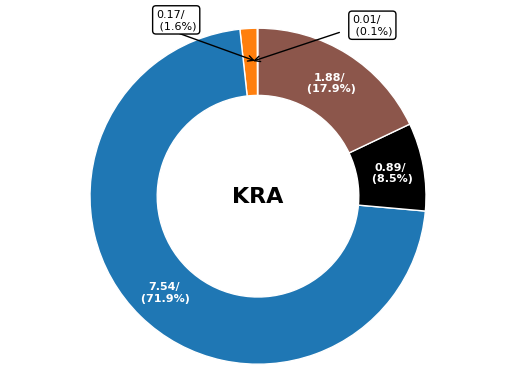

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_donut_contributions(stn):
    # Obtener los datos para la estación deseada
    data_mod_sa = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
    
    # Crear DataFrame para las contribuciones
    df = data_mod_sa.copy()
    df['oares'] = df['poares'] + df['soares']
    df['oatrf'] = df['poatrf'] + df['soatrf']
    df['oashp'] = df['poashp'] + df['soashp']
    df['oagfs'] = df['poagfs'] + df['soagfs']
    df['oaoth'] = df['poaoth'] + df['soaoth']
    
    # Eliminar columnas sobrantes
    columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
    df = df.drop(columns=columnas_a_eliminar)
    
    # Ordenar las categorías
    orden_categorias = ['oashp', 'oagfs', 'oares', 'oatrf', 'oaoth']
    df = df[orden_categorias]
    
    # Calcular la contribución media anual
    contribucion_media_anual = df.mean()
    
    # Obtener nombres de categorías y valores
    categorias = contribucion_media_anual.index
    valores = contribucion_media_anual.values
    
    # Define una paleta de colores para las categorías
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#2ca02c',
        'oaoth': '#8c564b'
    }
    
    # Obtener colores correspondientes a las categorías
    colores_categorias = [colores.get(cat, 'gray') for cat in categorias]
    
    # Etiquetas personalizadas para las categorías
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RES',
        'oatrf': 'TRF',
        'oashp': 'SHP',
        'oaoth': 'OTH'
    }
    
    # Obtener etiquetas personalizadas correspondientes a las categorías
    etiquetas_categorias = [etiquetas_personalizadas.get(cat, cat) for cat in categorias]
    
    # Crear un gráfico de donut
    fig, ax = plt.subplots()
    wedges, _ = ax.pie(valores, labels=None, autopct=None, startangle=90, wedgeprops=dict(width=0.4, edgecolor='w'),
                       colors=colores_categorias, textprops={'fontsize': 10, 'color': 'black', 'fontweight': 'bold'})

    # Agregar el nombre de la estación en el centro
    ax.text(0, 0, stn, ha='center', va='center', fontsize=16, fontweight='bold')
    fontsize = 8
    # Añadir los valores absolutos y los porcentajes al interior del sector del donut
    for wedge, etiqueta, valor in zip(wedges, etiquetas_categorias, valores):
        angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
        x = 0.8 * np.cos(np.deg2rad(angle))
        y = 0.8 * np.sin(np.deg2rad(angle))
        #ax.text(x, y, f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', 
        #        ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        print(wedge.theta2 - wedge.theta1)
        if (wedge.theta2 - wedge.theta1) == 2.407016381621361:
            #this is for BCN
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 25),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
                
        elif (wedge.theta2 - wedge.theta1) < 4 and (wedge.theta2 - wedge.theta1) > 3:
            #for MSY
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) > 2 and (wedge.theta2 - wedge.theta1) < 3:
            if stn in ['MSY', 'IPR', 'HYY']:
                ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                    textcoords='offset points', fontsize=fontsize,
                                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            elif stn in ['PAY']:
                ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                    textcoords='offset points', fontsize=fontsize,
                                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            elif stn in ['SIR']:
                if (wedge.theta2 - wedge.theta1) == 2.3551327362656593:
                    ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
                    ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                        textcoords='offset points', fontsize=fontsize,
                                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
                elif (wedge.theta2 - wedge.theta1) == 2.2840231843292713:
                    ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                    ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 20),
                                        textcoords='offset points', fontsize=fontsize,
                                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

        elif (wedge.theta2 - wedge.theta1) > 5 and (wedge.theta2 - wedge.theta1) < 7:
            
            if stn in ['KRA']:
                if (wedge.theta2 - wedge.theta1) == 5.89950866997242:
                    #for KRA
                    ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                    ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(-68, 24),
                                        textcoords='offset points', fontsize=fontsize,
                                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            else:
            #for HEL
                ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
                ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                    textcoords='offset points', fontsize=fontsize,
                                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) == 0.2917920076288283:
            #for KRA
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(68, 20),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

            
        elif (wedge.theta2 - wedge.theta1) == 1.004049489274621:
            #for PAY
            ax.annotate('', xy=(x, y), xytext=(-.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) == 1.9844325073063374:
            #for OPE
            ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        elif (wedge.theta2 - wedge.theta1) == 0.9832404926419258:
            #for RIG
            ax.annotate('', xy=(x, y), xytext=(.5, .98), arrowprops=dict(arrowstyle='->'))
            ax.annotate(f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', xy=(x, y), xytext=(60, 24),
                                textcoords='offset points', fontsize=fontsize,
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
            
        else:
            # Add the text label to the pie chart changed angle 0
            ax.text(x, y, f'{valor:.2f}/\n ({valor/sum(valores)*100:.1f}%)', fontsize=fontsize, color='white',
                    fontweight='bold', ha='center', va='center', rotation=0)


    # Aspecto de donut (círculo en el centro)
    circle = plt.Circle((0, 0), 0.2, color='white')
    ax.add_artist(circle)

    # Título
    #ax.set_title("Contribución Media Anual")

    # Mostrar el gráfico de donut
    plt.axis('equal')  # Para asegurar que el gráfico sea circular
    plt.show()
# Llama a la función con el nombre de la estación
plot_donut_contributions('KRA')


In [40]:
#sa data
path = '/home/hnavarro/Desktop/PHD_BSC/GIT/absorption/NInventory/obs/mass_concentration/source_app/'

In [45]:
def get_apportion(stn):
    '''
    avaliable stations: DEM, BCN, HEL, HYY, KRA, and MAR
    '''
    station = dict_of_names['acr_first'][stn]
    df = pd.read_csv(path+f'sa_oa_2018_{station}.csv', index_col=0, parse_dates=True)
    #df = df.resample('M').mean()
    return df

In [106]:
get_apportion('BCN').columns

Index(['OA cooking', 'OA traffic', 'OA biomass burning', 'SOA'], dtype='object')

In [530]:
# Configuraciones de colores y etiquetas
etiquetas_mod = {
    'oagfs': 'GFAS',
    'oares': 'RES',
    'oatrf': 'TRF',
    'oashp': 'SHP',
    'oaoth': 'OTH',
    'soa': 'SOA',
    'poares': 'RES',
    'poatrf': 'TRF',
    'poashp': 'SHP',
    'poagfs': 'GFAS',
    'poaoth': 'OTH',
}

colores_mod = {
    'RES': '#1f77b4',  # Azul claro
    'GFAS': '#ff7f0e',  # Naranja
    'TRF': '#000000',  # Negro mate
    'SHP': '#9467bd',  # Morado
    'OTH': '#8c564b',  # Marrón
    'SOA': '#4CAF50'   # Verde mate
}

colores_obs = {
    'COO': '#0088ce',  # Azul
    'TRF': '#000000',  # same as in model
    'BBU': '#ff7f0e',  # same as in gfas
    'SOA': '#4CAF50',   # Morado
    'COF': 'brown',
    'IND': 'red'
}

etiquetas_obs = {
    'BCN': {
        'OA cooking': 'COO',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBU',
        'SOA': 'SOA',
    },
    'HYY': {
        'SOA': 'SOA'
    },
    'DEM': {
        'OA cooking': 'COO',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBU',
        'SOA': 'SOA',

    },
    'HEL': {
        'Coffee': 'COF',
        'OA traffic': 'TRF',
        'SOA': 'SOA'
    },
    'KRA':{
        'OA cooking': 'COO',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBU',
        'SOA': 'SOA',
    },
    'MAR': {
        'OA cooking': 'COO',
        'OA traffic': 'TRF',
        'OA biomass burning': 'BBU',
        'SOA': 'SOA',
        'Sh-IndOA': 'IND',
    }

}

In [531]:
def get_cont_perc_abs_obs(stn):
    df_obs = get_apportion(stn)
    # Calcular la suma total anual de cada columna
    cont_total_anual_obs = df_obs.resample('A').sum()

    # Calcular la suma total anual de todas las columnas
    cont_total_anual_obs_tot = df_obs.resample('A').sum().sum(axis=1)

    # Calcular la contribución porcentual de cada columna como porcentaje del total anual
    cont_total_anual_obs_perc = np.round((cont_total_anual_obs.div(cont_total_anual_obs_tot, axis=0)) * 100, 1)
    #obtenemos tambien los valores absolutos
    cont_media_anual_obs = np.round(df_obs.resample('A').mean(), 2)

    return cont_total_anual_obs_perc, cont_media_anual_obs

In [532]:
get_cont_perc_abs_obs('MAR')

(            OA traffic  OA cooking  Sh-IndOA  OA biomass burning   SOA
 date                                                                  
 2018-12-31        10.9        12.5       3.5                16.8  56.3,
             OA traffic  OA cooking  Sh-IndOA  OA biomass burning   SOA
 date                                                                  
 2018-12-31        0.55        0.63      0.18                0.84  2.82)

In [518]:
obs_perc, obs_abs = get_cont_perc_abs_obs('BCN')

In [519]:
def get_cont_perc_abs_mod(stn, soa=False):
    df = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]))
    if soa:
        df['soa'] = df['soares'] + df['soatrf'] + df['soashp'] + df['soagfs'] + df['soaoth'] 
        df = df.drop(columns=['soares', 'soatrf', 'soashp', 'soagfs', 'soaoth'])
        df_mean_cont = np.round(df.resample('A').mean(), 2)
        df_sum_cont = df.resample('A').sum()
        df_cont_tot = df_sum_cont.sum(axis=1)
        #calculando contribucion porcentual
        df_cont_perc = np.round((df_sum_cont.div(df_cont_tot, axis=0)) * 100, 1)
        return df_cont_perc, df_mean_cont
    else:
        df['oares'] = df['poares'] + df['soares']
        df['oatrf'] = df['poatrf'] + df['soatrf']
        df['oashp'] = df['poashp'] + df['soashp']
        df['oagfs'] = df['poagfs'] + df['soagfs']
        df['oaoth'] = df['poaoth'] + df['soaoth']

        columnas_a_eliminar = ['poares', 'soares', 'poatrf', 'soatrf', 'poashp', 'soashp', 'poagfs', 'soagfs', 'poaoth', 'soaoth']
        df = df.drop(columns=columnas_a_eliminar)
        df_mean_cont = np.round(df.resample('A').mean(), 2)
        df_sum_cont = df.resample('A').sum()
        df_cont_tot = df_sum_cont.sum(axis=1)
        #calculando contribucion porcentual
        df_cont_perc = np.round((df_sum_cont.div(df_cont_tot, axis=0)) * 100, 1)
        return df_cont_perc, df_mean_cont
    

In [520]:
get_cont_perc_abs_mod('BCN', soa=False)

(            oares  oatrf  oashp  oagfs  oaoth
 2018-12-31   68.0    7.0    4.2    0.7   20.1,
             oares  oatrf  oashp  oagfs  oaoth
 2018-12-31   3.68   0.38   0.23   0.04   1.09)

In [521]:
get_cont_perc_abs_mod('BCN', soa=True)

(            poares  poatrf  poashp  poagfs  poaoth   soa
 2018-12-31    68.0     1.9     3.9     0.5     7.2  18.5,
             poares  poatrf  poashp  poagfs  poaoth  soa
 2018-12-31    3.68    0.11    0.21    0.02    0.39  1.0)

In [533]:
#data
stn = 'MAR'
model_perc, model_abs = get_cont_perc_abs_mod(stn, soa=True)
obs_perc, obs_abs = get_cont_perc_abs_obs(stn)

In [534]:
obs_perc.columns

Index(['OA traffic', 'OA cooking', 'Sh-IndOA', 'OA biomass burning', 'SOA'], dtype='object')

In [535]:
#categories
categorias_mod = model_perc.columns
etiquetas_mod_pie = [etiquetas_mod[cat] for cat in categorias_mod]
colores_mod_pie = [colores_mod[etiqueta] for etiqueta in etiquetas_mod_pie]

In [536]:
#categories obs
categorias_obs = obs_perc.columns
colores_obs_pie = [colores_obs[etiquetas_obs[stn][cat]] for cat in categorias_obs]
etiquetas_obs_pie = [etiquetas_obs[stn][cat] for cat in categorias_obs]

In [537]:
def func(pct, allvals, i):
    absolute = allvals[i]  # Usar directamente el valor absoluto correspondiente
    return f"{pct:.1f}%\n({absolute:.2f})"  # Mostrar con dos decimales

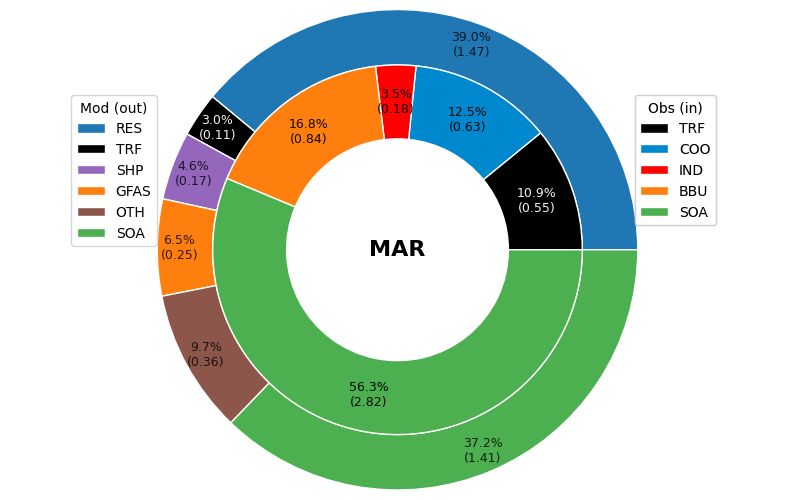

In [539]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('equal')

valores_model = [f'{pct:.1f}%\n({abs_val:.2f})' for pct, abs_val in zip(model_perc.values[0], model_abs.values[0])]

val_mod_iter = iter(valores_model)
outside_pie, texts_out, autotexts_out = ax.pie(model_perc.values[0], autopct=lambda pct: next(val_mod_iter), radius=1.3, colors=colores_mod_pie, #labels=etiquetas_mod_pie,\
                                 labeldistance=1.13, wedgeprops=dict(width=0.3, edgecolor='white'))
plt.setp(outside_pie, width=0.3, edgecolor='white')

for i, (pie_wedge, autotext) in enumerate(zip(outside_pie, autotexts_out)):
    ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    face_color = pie_wedge.get_facecolor()
    # Para sectores pequeños, ajustar la posición de las etiquetas
    if pie_wedge.theta2 - pie_wedge.theta1 < 10:  # Ajusta el umbral según sea necesario
        autotext.set_text('')  # Ocultar el texto automático
        # Determinar la posición de la anotación basada en el ángulo
        if y < 0:  # Si el sector está en la parte inferior
            xytext = (1.9 * x, 1.9 * y)  # Mover la etiqueta más hacia abajo
            connectionstyle = f"angle,angleA={ang-90},angleB=90,rad=0.2"  # Ajustar la conexión para que la flecha apunte hacia arriba
        else:
            xytext = (1.1 * x, 1.1 * y)  # Mover la etiqueta más hacia arriba
            connectionstyle = f"angle,angleA={ang+90},angleB=-90,rad=0.2"  # Ajustar la conexión para que la flecha apunte hacia abajo
        
        arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color="black")
        
        ax.annotate(valores_model[i], xy=(x, y), xytext=xytext,
                    horizontalalignment="center", 
                    arrowprops=arrowprops,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.72))
    else:
        if (face_color[0] == 0 and face_color[1] == 0 and face_color[2] == 0):
            autotext.set_color('white')
            autotext.set_position((x * 1.18, y * 1.18))
            autotext.set_alpha(0.95)
            autotext.set_fontsize(9)  # Ajusta esto según sea necesario
            autotext.set_horizontalalignment('center')
            autotext.set_verticalalignment('center')
        else:
            # Para sectores más grandes, centrar la etiqueta
            autotext.set_position((x * 1.18, y * 1.18))  # Ajusta la distancia al centro si es necesario
            autotext.set_alpha(0.8)
            autotext.set_fontsize(9)  # Ajusta esto según sea necesario
            autotext.set_horizontalalignment('center')
            autotext.set_verticalalignment('center')
'''
# Ajustar la rotación de las etiquetas del gráfico exterior
for text, pie_wedge in zip(texts_out, outside_pie):
    ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
    if ang > 180:
        ang -= 360
    # La alineación y la rotación dependen del ángulo
    text.set_rotation(ang)
    text.set_horizontalalignment('center' if ang == 0 else ('right' if ang < 0 else 'left'))
'''
#inside plot
valores_obs = [f'{pct:.1f}%\n({abs_val:.2f})' for pct, abs_val in zip(obs_perc.values[0], obs_abs.values[0])]

val_obs_iter = iter(valores_obs)
inside_pie, texts_in, autotexts_in = ax.pie(obs_perc.values[0], autopct=lambda pct: next(val_obs_iter), radius=1.3-0.3, colors=colores_obs_pie,\
                              wedgeprops=dict(width=0.4, edgecolor='white'))
plt.setp(inside_pie, width=0.4, edgecolor='white')

# Ajustar la transparencia y la posición del texto para el gráfico interior

for i, (pie_wedge, autotext) in enumerate(zip(inside_pie, autotexts_in)):
    ang = (pie_wedge.theta2 - pie_wedge.theta1) / 2 + pie_wedge.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
 
    face_color = pie_wedge.get_facecolor()
    # Verificar si el color es negro (RGB: 0, 0, 0)
    if (face_color[0] == 0 and face_color[1] == 0 and face_color[2] == 0):
        autotext.set_color('white')
        autotext.set_position((x * .8, y * .8))
        autotext.set_alpha(0.95)
        autotext.set_fontsize(9)  # Ajusta esto según sea necesario
        autotext.set_horizontalalignment('center')
        autotext.set_verticalalignment('center')
    else:
        autotext.set_position((x * .8, y * .8))  # Ajusta la distancia al centro si es necesario
        autotext.set_alpha(0.95)
        autotext.set_fontsize(9)  # Ajusta esto según sea necesario
        autotext.set_horizontalalignment('center')
        autotext.set_verticalalignment('center')
# Leyendas
legend_out = ax.legend(outside_pie, etiquetas_mod_pie, title="Mod (out)", loc="upper left", bbox_to_anchor=(0.07, 0.85))
legend_in = ax.legend(inside_pie, etiquetas_obs_pie, title="Obs (in)", loc="upper right", bbox_to_anchor=(.92, 0.85))

# Agregar las leyendas al gráfico
ax.add_artist(legend_out)
ax.add_artist(legend_in)
ax.text(0, 0, stn, ha='center', va='center', fontsize=16, fontweight='bold')
plt.margins(0,0)
plt.show()

## MASS STATISTICS

In [10]:
dict_of_names['stations'].values()

dict_values(['IPR', 'MSY', 'OPE', 'PAY', 'RIG', 'SIR', 'DEM', 'BCN', 'MAR', 'KRA', 'HEL', 'HYY'])

In [11]:

data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], 
            remove_negatives=True)
data_mod_tot = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]).sum(axis=1),
                            columns=['pm2p5oa'])

In [12]:
def calcular_metricas_estaciones():
    # Inicializa un DataFrame para almacenar los resultados
    resultados = []
    
    # Lista de nombres de estaciones (ajusta esto según tus necesidades)
    nombres_estaciones = dict_of_names['stations'].values()

    for stn in nombres_estaciones:
        # Obtener datos observados y modelados
        data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True)
        data_mod_tot = pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]).sum(axis=1),
                                    columns=['pm2p5oa'])

        # Calcular métricas
        corr = st.calculate_corr(data_obs, data_mod_tot)
        fb = st.calculate_fb(data_obs, data_mod_tot)
        fac2 = st.calculate_fac2(data_obs, data_mod_tot)

        # Obtener el nombre de la estación (asumiendo que tienes una forma de obtenerlo)
        nombre_estacion = ut.convention_names_stations()["acr_first"][stn]
        
        # Añadir los resultados al DataFrame
        resultados.append({
            'STN': stn,
            'CORR': corr,
            'FAC2': fac2,
            'FB': fb
        })
        

    # Convertir la lista de resultados en un DataFrame de pandas
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.set_index('STN')
    #ordenar alfabeticamente
    df_resultados = df_resultados.sort_index()
    return df_resultados

# Llamar a la función y mostrar los resultados
df_resultados = calcular_metricas_estaciones()
df_resultados

,CORR,FAC2,FB
STN,,,
BCN,0.33,69.90,24.81
DEM,0.40,80.37,-34.57
HEL,0.56,81.75,19.31
HYY,0.54,71.31,-16.75
IPR,0.68,65.12,-11.95
KRA,0.57,75.17,-32.17
MAR,0.68,76.09,-37.17
MSY,0.21,57.65,37.90
OPE,0.56,73.24,-17.75


In [13]:
import plotly.graph_objs as go
import plotly.io as pio

df_for_plotly = df_resultados.reset_index()


nombres_columnas = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df_for_plotly.columns.values]

# Crear una tabla Plotly
trace = go.Table(
    header=dict(values=nombres_columnas,
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df_for_plotly[col] for col in df_for_plotly.columns],
               fill_color='lavender',
               align='left'))

layout = go.Layout(
    width=700, 
    height=600
)

# Crear la figura con Plotly
fig = go.Figure(data=[trace], layout=layout)
if not os.path.exists('results_mass_stats'):
    os.makedirs('results_mass_stats')
# Guardar la figura como PNG usando Orca
pio.write_image(fig, 'results_mass_stats/tabla_resultados.png')



In [14]:
def calcular_metricas_estaciones_seasons():
    # Inicializar una lista para almacenar los resultados
    resultados = []

    # Lista de nombres de estaciones y temporadas
    nombres_estaciones = dict_of_names['stations'].values()
    seasons = ['DJF', 'MAM', 'JJA', 'SON']

    for stn in nombres_estaciones:
        # Diccionario para almacenar los resultados de la estación actual
        resultados_estacion = {'STN': stn}

        for season in seasons:
            try:
                # Obtener datos observados y modelados para la estación y temporada actual
                data_obs_season = sdg.season(dr.get_mass_obs(ut.convention_names_stations()["acr_first"][stn], remove_negatives=True))[season]
                data_mod_season = sdg.season(pd.DataFrame(dr.get_mass_mod(ut.convention_names_stations()["acr_first"][stn]).sum(axis=1), columns=['pm2p5oa']))[season]

                # Calcular métricas
                corr = st.calculate_corr(data_obs_season, data_mod_season)
                fb = st.calculate_fb(data_obs_season, data_mod_season)
                fac2 = st.calculate_fac2(data_obs_season, data_mod_season)
            except Exception as e:
                # En caso de un error (por ejemplo, datos faltantes), usar NaN para las métricas
                corr = np.nan
                fb = np.nan
                fac2 = np.nan

            # Añadir los resultados al diccionario de la estación
            resultados_estacion[('CORR', season)] = corr
            resultados_estacion[('FAC2', season)] = fac2
            resultados_estacion[('FB', season)] = fb

        # Añadir los resultados de la estación a la lista de resultados
        resultados.append(resultados_estacion)
    
    # Convertir la lista de resultados en un DataFrame de pandas
    df_resultados = pd.DataFrame(resultados)

    # Configurar 'STN' como índice del DataFrame
    df_resultados = df_resultados.set_index('STN')

    # Crear MultiIndex para las columnas
    df_resultados.columns = pd.MultiIndex.from_tuples(df_resultados.columns, names=['Metric', 'Season'])
    #sort alphabetically the by station name
    df_resultados = df_resultados.sort_index()
    
    return df_resultados

# Llamar a la función y mostrar los resultados
df_resultados_temporadas = calcular_metricas_estaciones_seasons()
df_resultados_temporadas

Metric,CORR,FAC2,FB,CORR,FAC2,FB,CORR,FAC2,FB,CORR,FAC2,FB
Season,DJF,DJF,DJF,MAM,MAM,MAM,JJA,JJA,JJA,SON,SON,SON
STN,,,,,,,,,,,,
BCN,0.58,41.82,70.13,0.62,80.00,28.34,0.80,86.96,-37.33,0.37,75.00,13.24
DEM,0.47,83.33,-0.40,0.41,86.21,-38.31,0.38,72.22,-50.43,0.58,83.02,-32.00
HEL,0.65,66.10,45.89,0.72,93.59,-3.64,NaN,NaN,NaN,NaN,NaN,NaN
HYY,0.94,23.53,84.43,0.64,79.17,-9.02,0.84,73.56,-52.56,0.83,72.13,-3.78
IPR,0.62,61.54,-50.53,0.33,49.32,17.31,0.26,75.28,17.77,0.52,71.43,21.84
KRA,0.53,73.33,-26.97,0.67,90.48,-20.53,0.55,65.43,-55.38,0.34,74.63,-32.54
MAR,0.64,75.00,-42.99,0.66,77.50,-23.41,NaN,NaN,NaN,NaN,NaN,NaN
MSY,0.66,14.29,95.00,0.39,57.14,54.86,0.63,86.96,-31.59,0.52,70.00,48.39


In [15]:
nombres_columnas = ['\n'.join(col).strip() for col in df_resultados_temporadas.columns.values]

# Crea una figura y un eje con matplotlib
fig, ax = plt.subplots(figsize=(12, 6))  # Ajusta el tamaño según sea necesario

# Oculta los ejes
ax.axis('off')

# Crea una tabla en el eje
tabla = ax.table(cellText=df_resultados_temporadas.values, 
                 colLabels=nombres_columnas, 
                 rowLabels=df_resultados_temporadas.index, 
                 cellLoc = 'center', rowLoc = 'center',
                 loc='center')

# Estilo al estilo LaTeX
# Desactivar todas las líneas de la cuadrícula excepto las del encabezado y la del final
for key, cell in tabla.get_celld().items():
    if key[1] == -1:  # Encabezado
        cell.set_linewidth(1)
        cell.set_edgecolor('black')
    else:
        cell.set_linewidth(1)
        cell.set_edgecolor('gray')  # Poner el mismo color que el fondo

# Ajusta la altura del encabezado de la tabla
# Itera solo sobre las celdas del encabezado
for col in range(len(nombres_columnas)):
    tabla[(0, col)].set_height(0.07)  # Ajusta este valor según sea necesario

# Ajusta la escala de la tabla
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)  # Ajusta el tamaño de la fuente según sea necesario
tabla.scale(1.2, 1.2)  # Ajusta el tamaño de la celda según sea necesario


#crear una carpeta para guardar los resultados
if not os.path.exists('results_mass_stats'):
    os.makedirs('results_mass_stats')
# Guarda la figura
plt.savefig('results_mass_stats/tabla_resultados_by_season.png', bbox_inches='tight', dpi=300)